In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
import sys
sys.path.append('src/')

import csv
from utils import DEFAULT_PALETTE
from WADParser import WAD_file
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import struct
import re
from copy import deepcopy

In [16]:
w = WAD_file('WADs/DOOM2.WAD')

2025-03-01 19:17:39.438 | INFO     | WADParser:__init__:33 - DOOM IWAD found at WADs/DOOM2.WAD.
2025-03-01 19:17:39.439 | INFO     | WADParser:_get_palette:105 - Palette extracted.
2025-03-01 19:17:39.440 | INFO     | WADParser:_parse_levels:145 - 32 levels found in this WAD.
2025-03-01 19:17:39.440 | INFO     | WADParser:_parse_by_markers:175 - 147 FLATS found in this WAD.
2025-03-01 19:17:39.440 | INFO     | WADParser:_parse_by_markers:175 - 1381 SPRITES found in this WAD.
2025-03-01 19:17:39.503 | INFO     | WADParser:_parse_things:117 - DOOM THINGS loaded.


In [17]:
w.map('MAP01')

(75968, 1532)


defaultdict(list,
            {'walls': [array([[-448,  768],
                     [-192,  768]]),
              array([[ -64,  704],
                     [-128,  704]]),
              array([[ 64, 768],
                     [-64, 704]]),
              array([[-64, 632],
                     [-64, 696]]),
              array([[-64, 696],
                     [ 56, 696]]),
              array([[ 56, 632],
                     [-64, 632]]),
              array([[ 64, 832],
                     [ 64, 768]]),
              array([[-256,  832],
                     [-384,  960]]),
              array([[-384,  960],
                     [-320, 1280]]),
              array([[ 128, 1280],
                     [ 192, 1280]]),
              array([[ 192, 1280],
                     [ 256,  960]]),
              array([[256, 960],
                     [128, 832]]),
              array([[128, 832],
                     [ 64, 832]]),
              array([[-192,  832],
                     [-256,  8

In [ ]:
def extract_map_info(map:str):
    map_info = {}
    vx_offset, vx_size = w.maps[map]['VERTEXES']
    w.wad.seek(vx_offset)
    lump = w.wad.read(vx_size)

    vertices = np.array([struct.unpack('<hh', lump[i:i+4]) for i in range(0, len(lump), 4)])

    l_offset, l_size = w.maps[map]['LINEDEFS']
    w.wad.seek(l_offset)
    lump = w.wad.read(l_size)

    linedefs = np.array([struct.unpack('<hhhhhhh', lump[i:i+14]) for i in range(0, len(lump), 14)]).astype(np.int16)

    lines = vertices[linedefs[:, 0:2]]
    flags = linedefs[:, 2]

    for line, flag in zip(lines, flags):
        if flag & 0x20: # Secret
            map_info['secret'].append(line)
        elif flag & 0x01:  # Impassable
            map_info['walls'].append(line)
        elif flag & 0x04: # Two-sided, can see through
            map_info['steps'].append(line)


    l_offset, l_size = w.maps[map]['THINGS']
    w.wad.seek(l_offset)
    lump = w.wad.read(l_size)

    things = np.array([struct.unpack('<hhhhh', lump[i:i+10]) for i in range(0, len(lump), 10)]).astype(np.int16)

    map_info['things'] = things

    return map_info


In [ ]:
vx_offset, vx_size = w.maps['MAP02']['VERTEXES']
w.wad.seek(vx_offset)
lump = w.wad.read(vx_size)

vertices = np.array([struct.unpack('<hh', lump[i:i+4]) for i in range(0, len(lump), 4)])
vertices.shape

(501, 2)

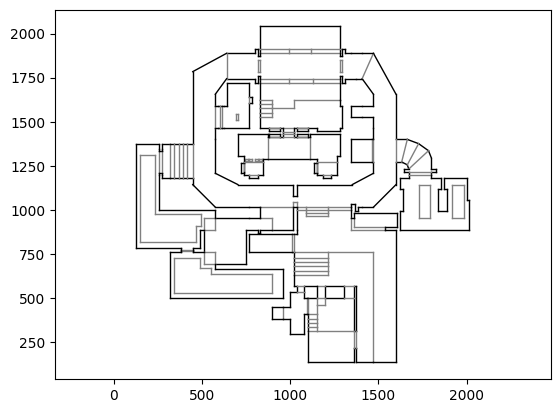

In [14]:
l_offset, l_size = w.maps['MAP02']['LINEDEFS']
w.wad.seek(l_offset)
lump = w.wad.read(l_size)

linedefs = np.array([struct.unpack('<hhhhhhh', lump[i:i+14]) for i in range(0, len(lump), 14)]).astype(np.int16)

lines = vertices[linedefs[:, 0:2]]
flags = linedefs[:, 2]

for line, flag in zip(lines, flags):
    
    if flag & 0x01:  # Impassable
        plt.plot(line[:, 0], line[:, 1], color='black', linewidth=1)

    if flag & 0x04:  # Two-sided
        plt.plot(line[:, 0], line[:, 1], color='grey', linewidth=1)
    
    if flag & 0x20:  # Secret (not displayed on automap)
        plt.plot(line[:, 0], line[:, 1], color='orange', linewidth=1)

plt.axis('equal')
plt.show()      

In [7]:
d = {int(k): int(v) for k, v in zip(linedefs[:, 0], linedefs[:, 1])}
lines = []
idx = 0

while True:
    if len(d) == 0: break
    start = next(iter(d))
    line = [start]
    while True:
        next_vertex = d.pop(start, None)
        if next_vertex is None:
            break
        line.append(next_vertex)
        start = next_vertex
    lines.append(line)

In [132]:
d = {int(k): int(v) for k, v in zip(linedefs[:, 0], linedefs[:, 1])}
d2 = d.copy()
lines = []
idx = 0

while True:
    if len(d) == 0: break
    start = next(iter(d))
    line = [start]
    while True:
        next_vertex = d.pop(start, None)
        save_vertex = d2.get(start, None)

        if (next_vertex is None) & (save_vertex is None):
            break
        elif (next_vertex is None) & (save_vertex is not None):
            line.append(save_vertex)
            break

        line.append(next_vertex)
        start = next_vertex
    lines.append(line)


In [9]:
l_offset, l_size = w.maps['MAP02']['THINGS']
w.wad.seek(l_offset)
lump = w.wad.read(l_size)

things = np.array([struct.unpack('<hhhhh', lump[i:i+10]) for i in range(0, len(lump), 10)]).astype(np.int16)

things

array([[1104, 1984,  270,    1,    7],
       [ 944, 1984,  270,    2,    7],
       [1008, 1984,  270,    3,    7],
       [1056, 1984,  270,    4,    7],
       [1056, 1488,  270, 3004,    7],
       [ 912, 1488,  270, 3004,    7],
       [1072, 1376,   90, 3004,    7],
       [ 912, 1376,   90, 3004,    7],
       [1200, 1232,   90,    9,    7],
       [ 768, 1232,   90,    9,    7],
       [1264, 1520,    0, 3004,    7],
       [1312,  960,   90, 3004,   15],
       [1056,  960,   90, 3004,   15],
       [1248,  960,   90,    9,   15],
       [1152,  928,   90,    9,   14],
       [1040,  496,   90,    9,   15],
       [1040,  448,   90,    9,   14],
       [1312,  176,   90,    9,   15],
       [1152,  176,   90,    9,   14],
       [1200,  176,   90,    9,   14],
       [1264,  176,   90,    9,   12],
       [ 800,  816,    0, 3002,    6],
       [ 848,  800,    0,    9,    7],
       [ 896,  816,    0,    9,    6],
       [ 960,  816,    0,    9,   12],
       [1392,  944,  270,

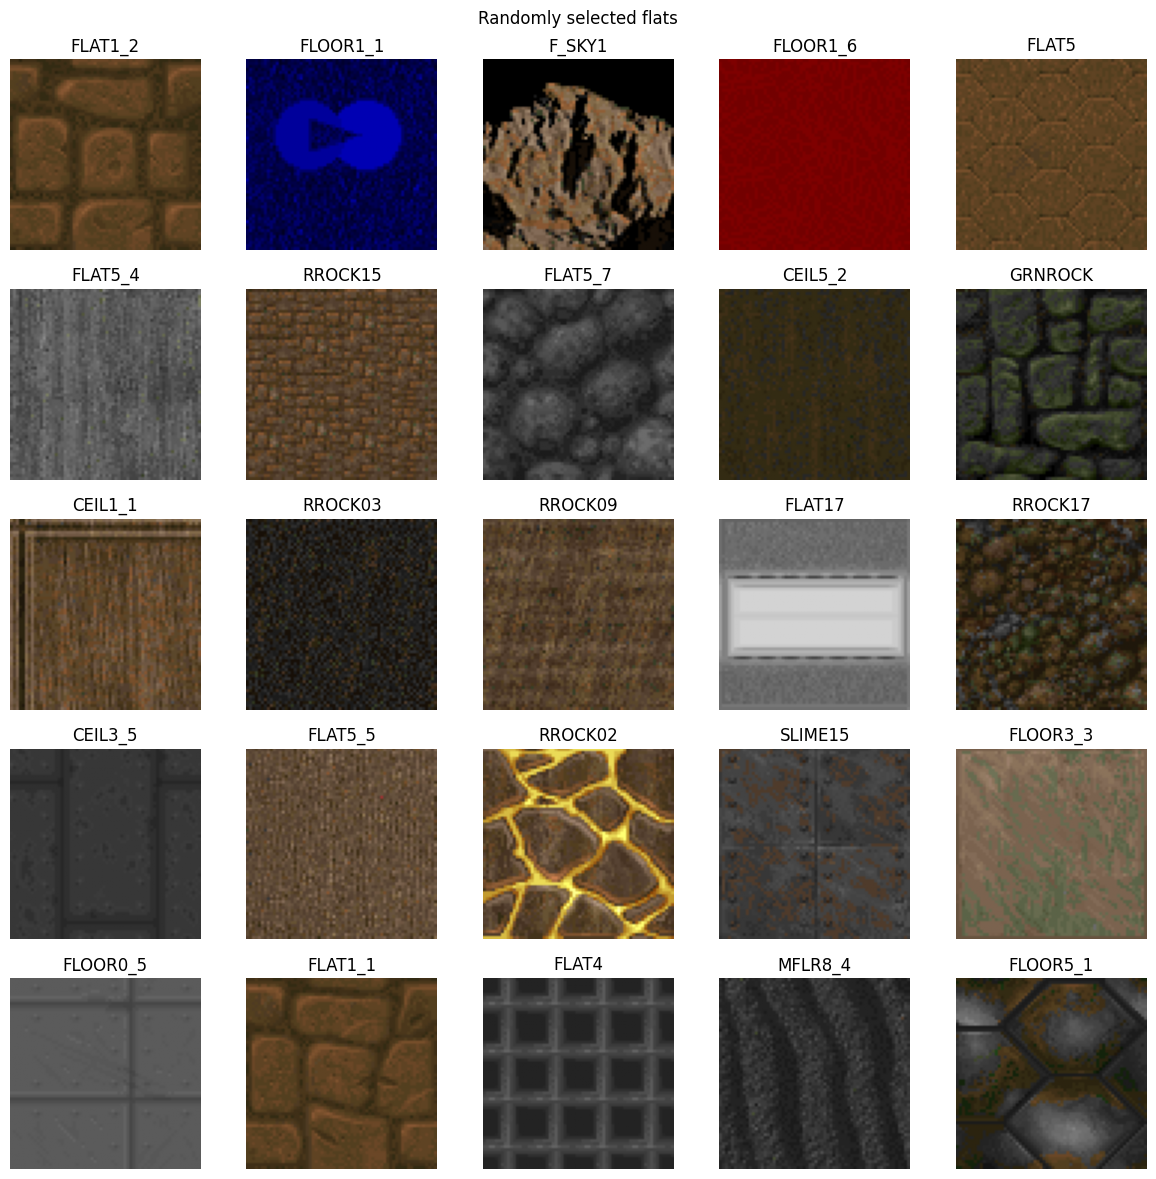

In [10]:
n_flats = 25
fig, ax = plt.subplots(5, 5, figsize=(12, 12))
ax = ax.ravel()

all_flat_names = list(w.flats.keys())
selected_flats = np.random.choice(all_flat_names, size=n_flats, replace=False)

for i, flat_name in enumerate(selected_flats):

    rgb_image = w.draw_flat(*w.flats[flat_name])

    ax[i].imshow(rgb_image / 255, aspect='equal')
    ax[i].set_title(flat_name)
    ax[i].axis('off')

fig.suptitle('Randomly selected flats')
fig.tight_layout(pad=1.2)

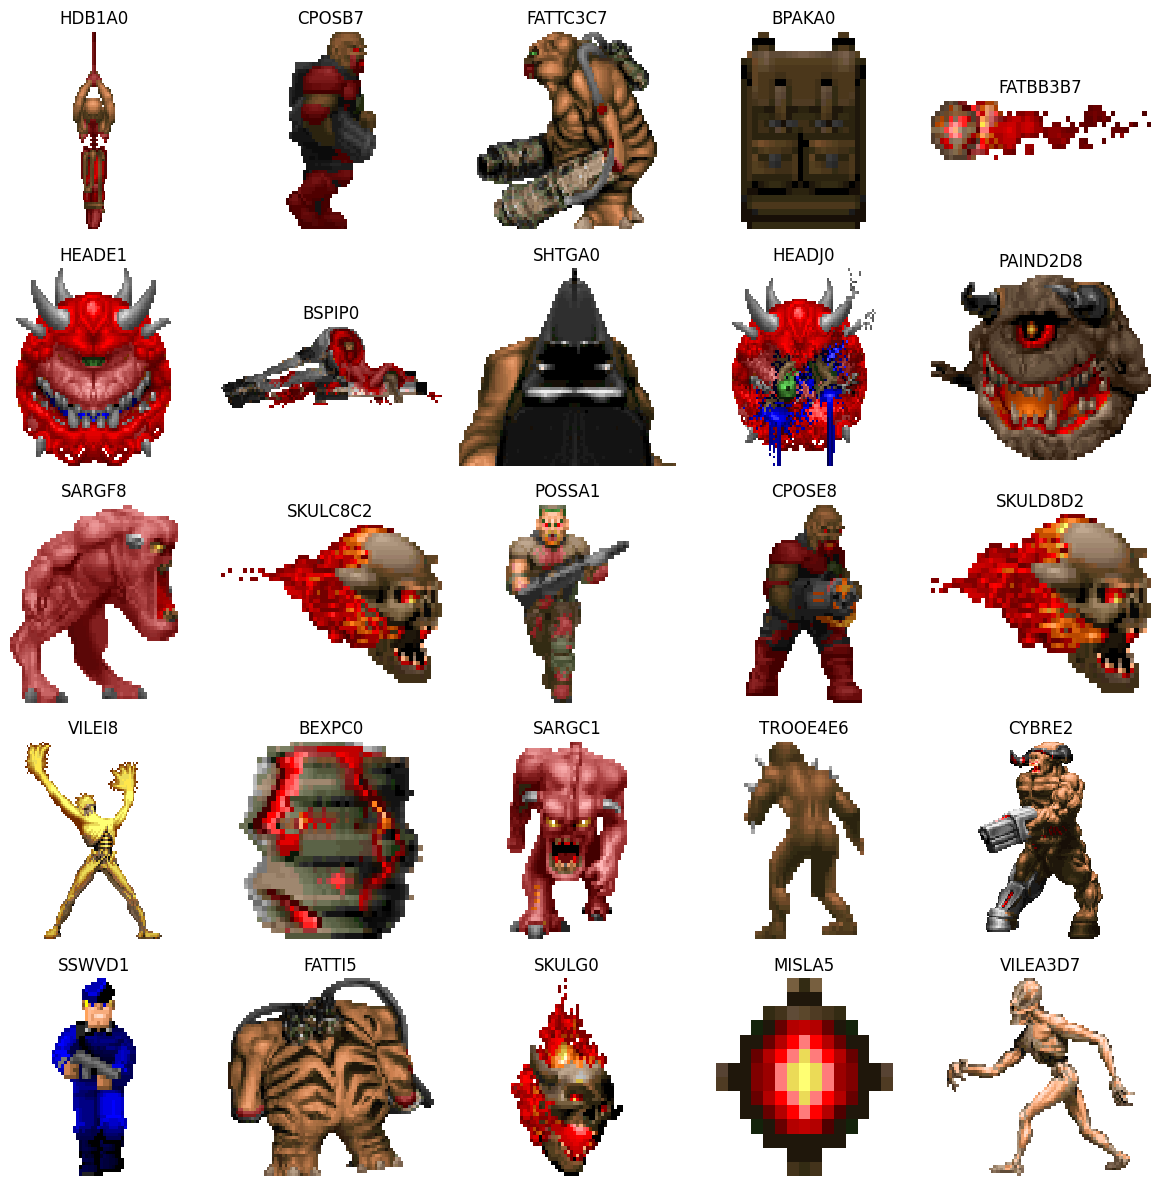

In [11]:
n_sprites = 25
fig, ax = plt.subplots(5, 5, figsize=(12, 12))
ax = ax.ravel()

all_sprite_names = list(w.sprites.keys())
selected_sprites = np.random.choice(all_sprite_names, size=n_sprites, replace=False)

for i, sprite_name in enumerate(selected_sprites):

    rgb_image = w.draw_patch(*w.sprites[sprite_name])

    # Original DOOM had non-square pixels!
    ax[i].imshow(rgb_image / 255, aspect=1.2, interpolation='nearest') 
    ax[i].set_title(sprite_name)
    ax[i].axis('off')

fig.tight_layout(pad=1.2)

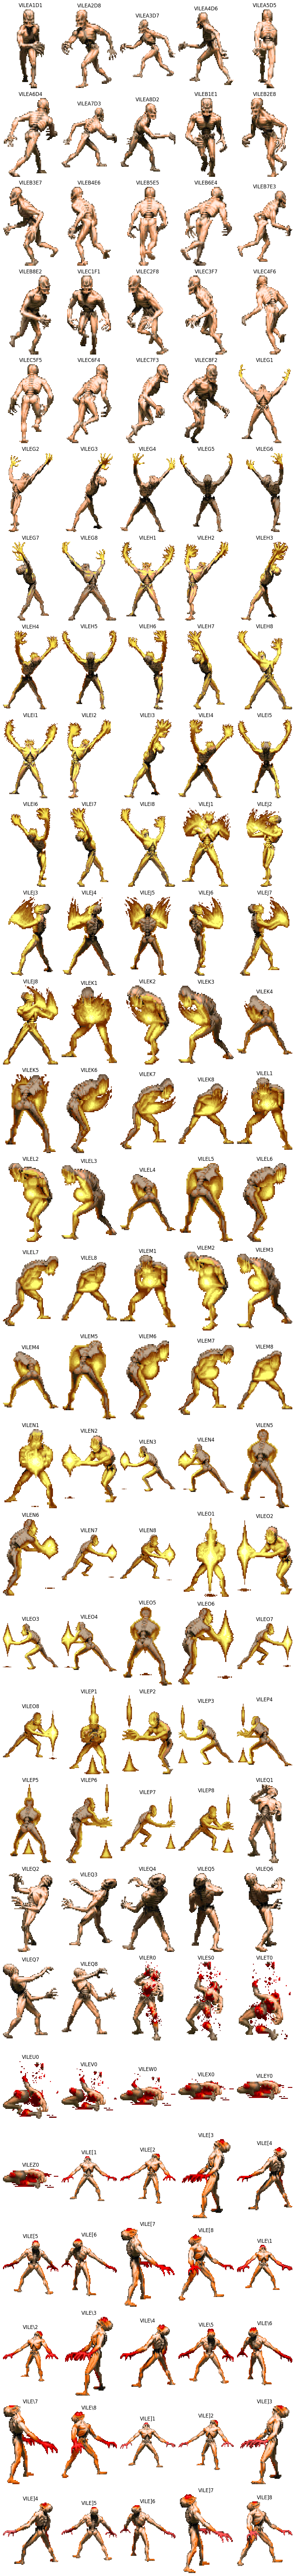

In [12]:
sprite_name = 'VILE'

sprite_list = w.spritesheets[sprite_name]
ncols=5
nrows = int(np.ceil(len(sprite_list) / ncols))

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10, 3*nrows))
ax = ax.ravel()

for i, (name, offset, size) in enumerate(sprite_list):
    
    rgb_image = w.draw_patch(offset, size)
    ax[i].imshow(rgb_image / 255, aspect=1.2, interpolation='nearest')
    ax[i].set_title(name)
    ax[i].axis('off')

[ax[i].set_visible(False) for i in range(len(sprite_list), len(ax))]
fig.tight_layout(pad=0.8)

In [10]:
# Example linedefs array (replace this with your actual data)
linedefs = np.array([[1, 2], [2, 3], [3, 4], [4, 1]])

d = {int(k): int(v) for k, v in zip(linedefs[:, 0], linedefs[:, 1])}
lines = []
idx = 0

while True:
    if len(d) == 0:
        break
    start = next(iter(d))
    line = [start]
    while True:
        next_vertex = d.pop(start, None)
        if next_vertex is None:
            break
        line.append(next_vertex)
        start = next_vertex
    lines.append(line)

print(lines)

[[1, 2, 3, 4, 1]]
